In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import os

In [11]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [12]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "banana diseases",  # Use the path to the extracted folder
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

# Verify the dataset
for images, labels in dataset.take(1):
    print("Batch shape:", images.shape)
    print("Labels shape:", labels.shape)


Found 3279 files belonging to 3 classes.
Batch shape: (32, 256, 256, 3)
Labels shape: (32,)


In [13]:
class_names = dataset.class_names
class_names

['Banana Black Sigatoka Disease',
 'Banana Healthy Leaf',
 'Banana Panama Disease']

In [14]:
len(dataset)

103

In [15]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 0 1 0 1 0 1 0 1 1 2 2 0 0 1 1 0 2 2 0 2 0 1 1 1 1 0 1 0 0 2]


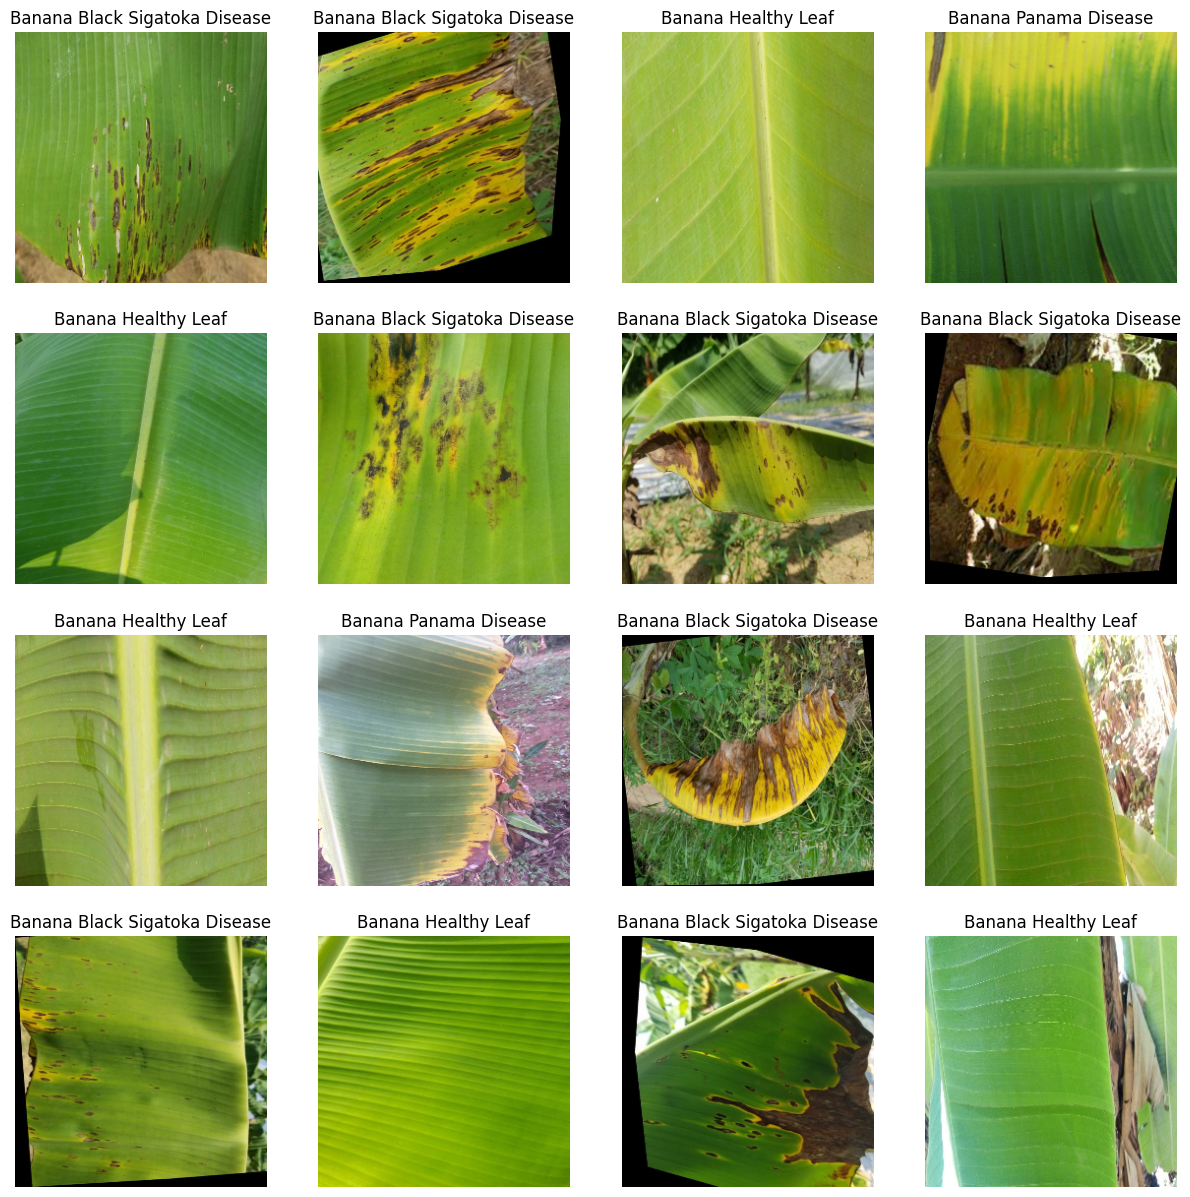

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1) # Changed the grid to 4x4 to accommodate 16 images
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [17]:
len(dataset)

103

In [29]:
train_size = 0.8
len(dataset)*train_size

82.4

In [30]:
train_ds = dataset.take(82)
len(train_ds)

82

In [31]:
test_ds = dataset.skip(82)
len(test_ds)

21

In [32]:
val_size=0.1
len(dataset)*val_size

10.3

In [33]:
val_ds = test_ds.take(10)
len(val_ds)

10

In [34]:
test_ds = test_ds.skip(10)
len(test_ds)

11

In [35]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [36]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [37]:
len(train_ds)

82

In [38]:
len(val_ds)

10

In [39]:
len(test_ds)

11

In [40]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [41]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0 / 255)
])



In [42]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2)
])


In [43]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)
     

C:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [44]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
model.compile(
    optimizer='adam',  # Specifies the optimizer to use
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # Specifies the loss function
    metrics=['accuracy']  # Specifies the metrics to monitor during training
)


In [46]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 65s 633ms/step - accuracy: 0.4290 - loss: 1.0424 - val_accuracy: 0.6375 - val_loss: 0.8029
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 50s 605ms/step - accuracy: 0.6593 - loss: 0.7475 - val_accuracy: 0.8000 - val_loss: 0.5205
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 51s 626ms/step - accuracy: 0.7770 - loss: 0.5559 - val_accuracy: 0.7969 - val_loss: 0.5020
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 56s 688ms/step - accuracy: 0.8008 - loss: 0.5041 - val_accuracy: 0.8562 - val_loss: 0.3807
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 54s 654ms/step - accuracy: 0.8502 - loss: 0.3807 - val_accuracy: 0.8813 - val_loss: 0.3317
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 52s 640ms/step - accuracy: 0.8668 - loss: 0.3212 - val_accuracy: 0.8906 - val_loss: 0.2913
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 53s 641ms/step - accuracy: 0.8798 - loss: 0.3061 - val_accuracy: 0.9187 - val_loss: 0.2316
Epoch 8/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 51s 627ms/step - accuracy: 0.9120 - loss: 0.2385 - val_accu

In [47]:
scores = model.evaluate(test_ds)

11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 208ms/step - accuracy: 0.9826 - loss: 0.0854


In [48]:
scores

[0.10905084758996964, 0.9772727489471436]

In [49]:
history

In [50]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 82}

In [51]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [52]:
type(history.history['loss'])

list

In [53]:
len(history.history['loss'])

50

In [54]:
history.history['loss'][:5]

[0.9608471989631653,
 0.7198845744132996,
 0.5509541630744934,
 0.4630044102668762,
 0.39382171630859375]

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

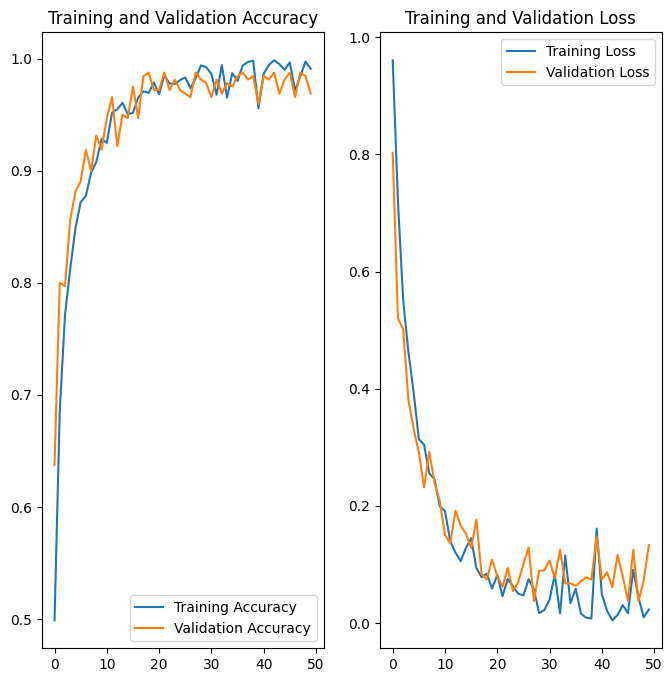

In [56]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

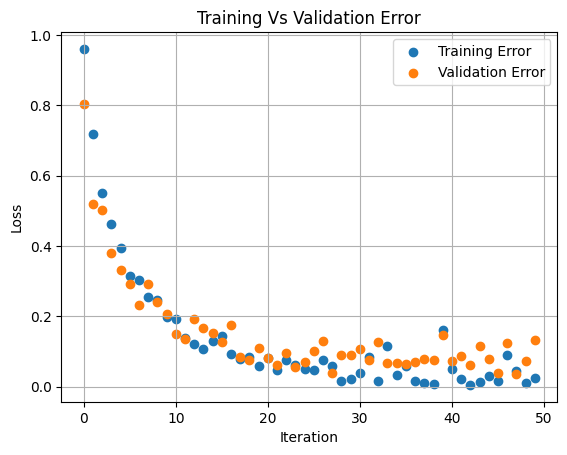

In [57]:
plt.scatter(x=history.epoch,y=history.history['loss'],label='Training Error')
plt.scatter(x=history.epoch,y=history.history['val_loss'],label='Validation Error')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

first image to predict
actual label: Banana Black Sigatoka Disease
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
predicted label: Banana Black Sigatoka Disease


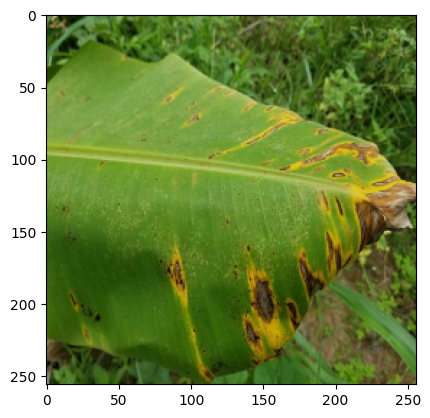

In [61]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


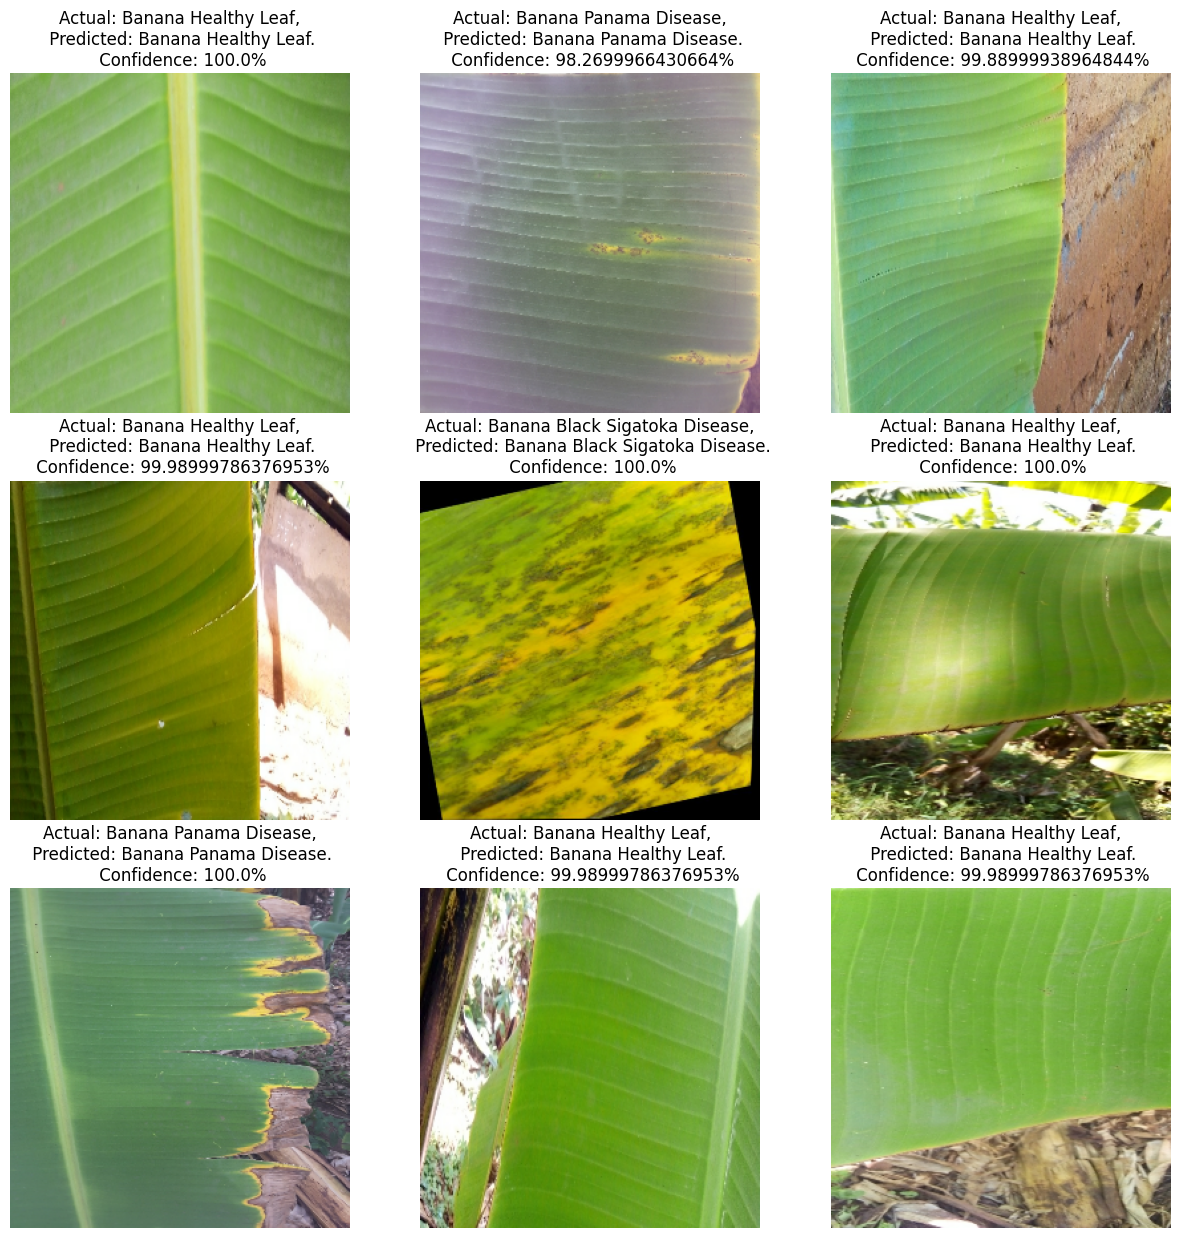

In [62]:
import numpy as np

def predict(model, image):
    """
    Predicts the class of an image using the given model.

    Args:
        model: The trained Keras model.
        image: The image to predict.

    Returns:
        A tuple containing the predicted class name and confidence score.
    """
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    prediction = model.predict(image)
    predicted_class_index = np.argmax(prediction)
    confidence = round(100 * (np.max(prediction)), 2)
    predicted_class = class_names[predicted_class_index]

    return predicted_class, confidence

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy()) # Call the defined 'predict' function
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")